In [6]:
#imports
import math
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.layers.experimental import RandomFourierFeatures

import matplotlib.pyplot as plt

Decision Tree (ID3)

Test results:


,Date,Trending,5%Change,HighVol,CloseAvg,DidWin,Predictions
626,12/31/2012,0,0,0,0,1,1
627,1/7/2013,0,0,0,0,1,1
628,1/14/2013,0,0,0,1,0,0
629,1/21/2013,0,0,0,0,1,1
630,1/28/2013,0,0,1,1,0,0
...,...,...,...,...,...,...,...
830,11/28/2016,-1,0,1,0,0,0
831,12/5/2016,-1,0,0,0,0,0
832,12/12/2016,-1,0,0,0,0,0
833,12/19/2016,0,0,0,0,1,1


Specificity is 0.719626168224299
Sensitivity is 0.7254901960784313
F1 Score: 0.7184466019417477



Validation results:


,Date,Trending,5%Change,HighVol,CloseAvg,DidWin,Predictions
835,1/2/2017,1,0,0,1,1,1
836,1/9/2017,1,0,0,1,1,1
837,1/16/2017,0,0,0,0,0,1
838,1/23/2017,0,0,1,0,1,1
839,1/30/2017,0,0,1,1,1,0
...,...,...,...,...,...,...,...
1039,11/30/2020,0,0,1,1,1,0
1040,12/7/2020,1,0,0,0,1,1
1041,12/14/2020,0,0,0,1,0,0
1042,12/21/2020,0,0,0,0,1,1


Specificity is 0.6966292134831461
Sensitivity is 0.7166666666666667
F1 Score: 0.7381974248927038



Test Accuracy: 72.25% of our trades are winning trades using this decision tree model.


Validation Accuracy: 70.81% of our trades are winning trades using this decision tree model.



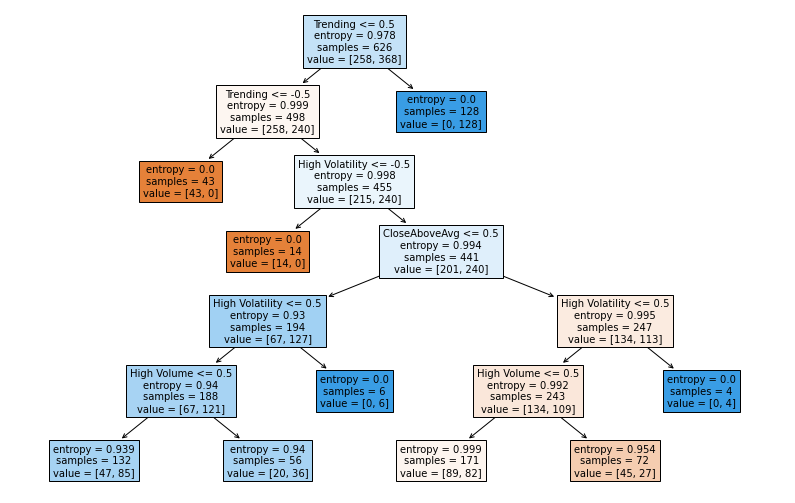

In [7]:
#Read Data:

#Take in DT data from our csv file
data = pd.read_csv('GoldWeekly_DT.csv')
data_DT = pd.DataFrame(data)

data_labels = data_DT['Date'].copy()
data_DT = data_DT.drop('Date', axis = 1)

#Preprocessing data:

#Split data for training and testing
X_train, X_Test_Val = train_test_split(data_DT, test_size = 0.4, train_size = 0.6, shuffle = False)
X_test, X_val = train_test_split(X_Test_Val, test_size = 0.5, train_size = 0.5, shuffle = False)
#Removing the labels from the data.
DT_train_labels = X_train['DidWin'].copy()
X_train = X_train.drop('DidWin', axis = 1)
DT_test_labels = X_test['DidWin'].copy()
X_test = X_test.drop('DidWin', axis = 1)
DT_val_labels = X_val['DidWin'].copy()
X_val = X_val.drop('DidWin', axis = 1)



#Performance Assessment

#Create Decision Tree Model for Entropy
def DTClassifier(critiria, dataset, label):
    DT = DecisionTreeClassifier(criterion=critiria)
    DT_Model = DT.fit(X_train, DT_train_labels)
    
    #Predicting against Test data
    results = DT_Model.predict(dataset)
    
    result_df = pd.DataFrame(dataset)
    result_df = result_df.assign(DidWin = label, Predictions = results)
    
    result_df.insert(0, "Date", data_labels)
    display(result_df)
    #Finding Specificity and Sensitivity
    tn, fp, fn, tp = metrics.confusion_matrix(result_df.iloc[:,5], results).ravel()
    spec = tn/(tn + fp)
    sens = tp/(tp + fn)
    print("Specificity is", spec)
    print("Sensitivity is", sens)

    #Finding AUC
    false_Pos, true_Pos, thresh = metrics.roc_curve(result_df.iloc[:,5], results)
    auc = metrics.auc(false_Pos, true_Pos)
    #print("Area Under ROC curve:", auc) #not used for boolean results.

    #Finding F1
    f1_score = metrics.f1_score(result_df.iloc[:,5], results)
    print("F1 Score:", f1_score)
    print("\n")
    
    accuracy = ((tp+tn)/(tp+tn+fp+fn))
    return DT_Model, accuracy

print('Test results:')
test_DT_Model, test_accuracy = DTClassifier('entropy', X_test, DT_test_labels)
print('\nValidation results:')
val_DT_Model, val_accuracy = DTClassifier('entropy', X_val, DT_val_labels)


#Model Visualization

print('\nTest Accuracy: ' + str(round((100*test_accuracy), 2)) + '% of our trades are winning trades using this decision tree model.\n')
print('\nValidation Accuracy: ' + str(round((100*val_accuracy), 2)) + '% of our trades are winning trades using this decision tree model.\n')

plt.figure(figsize=(14, 9))
tree.plot_tree(val_DT_Model, filled=True, proportion=False, fontsize=10, feature_names=['Trending','High Volatility','High Volume','CloseAboveAvg'])
plt.show()


While Decision-Trees are great for finding out the biggest contributing factor due to it's easy visualization, they're not the best system for this dataset. When using Decision-Trees for this dataset, we're unable to find the exact amount of profit or loss from any given trade. It's possible that we're winning 72% of our weekly trades, while our losses are far greater than our gains. This system would still work better than keeping money in the bank, though it could easily be improved by comparing the entropy of multiple markets per week and picking the best model for that week. There are some weeks where gold would have a better entropy than silver or platinum, and some weeks it would be better to put your money in silver based on this model.

Explaining our tree plot using our weekly gold market data: Trending < 0.5 when the market is not uptrending for at least 3-weeks in a row. Trending < -0.5 when the market is not downtrending for at least 3 weeks.

High Volatility < -0.5 when there's greater than a 5% price drop. High Volatility < +0.5 when there's greater than a 5% price increase.

CloseAboveAvg = 0 when the weekly price ends below ((weeklyHigh + weeklyLow)/2), and equal to 1 when above. High Volume = 1 if there was a large amount of volume that week, otherwise it's 0.

SVM (Support Vector Regression)

[LibSVM][ -6.7763422   -6.91000834  -8.30164112  -5.22232296  -9.38112581
  -8.65818313   0.02182977  -0.37676317 -10.07716775  -3.74625066
  -7.41140437  -7.37688024  -5.19527249   3.11461732   3.47195187
  18.50324942  -8.49441402  -3.96621871  -1.25657195   1.85964757
  -6.43619777  -9.43513635  -8.90423387  -3.49449057   9.35221027
  12.01954409  -6.38579732  -4.36173514  -0.6995021   -8.60137242
   1.65997834   3.12374075  -5.89836452  -0.03682839  -8.79662171
  -3.51399617   2.7361066   -2.16404565  -1.78143466   4.57006109
  -2.29565381  -0.98102833  -4.46605428  -1.91907659  -3.07017338
  -2.76240432   0.50708225  -4.84306501   1.29724106  -7.37117447
   0.60478113  -2.71425568   3.62591193  -1.31411976  -2.3447731
  -0.42092262  -3.73939015  -6.00398126  -3.89682305  -3.05546887
  -8.03468093  -6.236175    -4.82999785   0.73303228   0.17076044
  -1.42702469  -4.6840846   -3.89429747  -1.36743558   1.32477735
  -4.46691316  -6.90744348  -4.33716139   0.08995493  -3.3559469
  -4

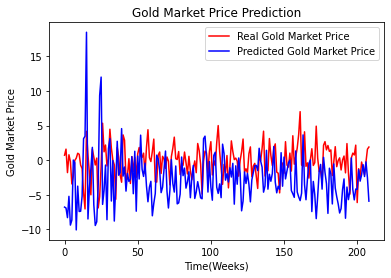

In [8]:
#Reading in Data
data_ANN = pd.read_csv('GoldWeekly2001-2021.csv')

data_ANN = data_ANN.drop('Did_Win', axis=1)
data_ANN = data_ANN.drop('Volume', axis=1)

for i in range(len(data_ANN)):
    if data_ANN.iloc[i,-1] == 0:
        continue
    else:
        data_ANN.iloc[i,-1] = data_ANN.iloc[i,-1] / data_ANN.iloc[i,-2] * 100

data_ANN.head(n=4)


#Preprocessing data:
data_labels = data_ANN['Date'].copy()
data_ANN = data_ANN.drop('Date', axis = 1)

#Split data for training and testing
X_train, X_Test_Val = train_test_split(data_ANN, test_size = 0.4, train_size = 0.6, shuffle = False)
X_test, X_val = train_test_split(X_Test_Val, test_size = 0.5, train_size = 0.5, shuffle = False)

#Removing the labels from the data.
train_labels = X_train['Profit'].copy()
X_train = X_train.drop('Profit', axis = 1)

test_labels = X_test['Profit'].copy()
X_test = X_test.drop('Profit', axis = 1)

val_labels = X_val['Profit'].copy()
X_val = X_val.drop('Profit', axis = 1)


arr_train_labels = np.array(train_labels)
arr_test_labels = np.array(test_labels)
arr_val_labels = np.array(val_labels)


#Creating SVR model and predicting against Test
reg = SVR(C=10, epsilon=0.1, kernel="linear", verbose=True, max_iter=-1)

reg.fit(X_train, arr_train_labels)

predictions = reg.predict(X_test)
print(predictions)



#Showing comparison between actual and predictions
currentMoney = 1000.0

print("If you invested $1000 from " + data_labels[627] + " to " + data_labels[835] + ".")

for i in range((len(X_test)-1)):
   if (float(predictions[i]) > 0.5):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : With our SVM(Support Vector Regression) Model.") #then do this for validation.

currentMoney = 1000.0

for i in range((len(X_test)-1)):
    #If we blindly left our money in the market as opposed to using our model.
   if (True):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : Without our Model.") #then do this for validation.

print("\nAs you can see, this was a bad time period to invest in the Gold Market, yet our model was able to limit our losses throughout this time period.")




#Visualizing results
plt.plot(arr_test_labels, color = 'red', label = 'Real Gold Market Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Gold Market Price')
plt.title('Gold Market Price Prediction')
plt.xlabel('Time(Weeks)')
plt.ylabel('Gold Market Price')
plt.legend()
plt.show()


ANN (RNN using LSTM)

In [10]:
#Reading Data
data_ANN = pd.read_csv('GoldWeekly2001-2021.csv')

data_ANN = data_ANN.drop('Did_Win', axis=1)
data_ANN = data_ANN.drop('Volume', axis=1)

for i in range(len(data_ANN)):
    if data_ANN.iloc[i,-1] == 0:
        continue
    else:
        data_ANN.iloc[i,-1] = data_ANN.iloc[i,-1] / data_ANN.iloc[i,-2] * 100

data_ANN.head(n=4)


#Preprocessing data:
data_labels = data_ANN['Date'].copy()
data_ANN = data_ANN.drop('Date', axis = 1)

#Split data for training and testing
X_train, X_Test_Val = train_test_split(data_ANN, test_size = 0.4, train_size = 0.6, shuffle = False)
X_test, X_val = train_test_split(X_Test_Val, test_size = 0.5, train_size = 0.5, shuffle = False)

#Removing the labels from the data.
train_labels = X_train['Profit'].copy()
X_train = X_train.drop('Profit', axis = 1)

test_labels = X_test['Profit'].copy()
X_test = X_test.drop('Profit', axis = 1)

val_labels = X_val['Profit'].copy()
X_val = X_val.drop('Profit', axis = 1)


arr_train_labels = np.array(train_labels)
arr_test_labels = np.array(test_labels)
arr_val_labels = np.array(val_labels)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)


#Reshaping Data for Keras LSTM
def univariate_processing(variable, window):
    # create empty 2D matrix from variable
    V = np.empty((len(variable)-window+1, window))
    
    # take each row/time window
    for i in range(V.shape[0]):
        V[i,:] = variable[i : i+window]
    
    V = V.astype(np.float32) # set common data type
    
    return V

def RNN_regprep(df, y, len_input, len_pred):
    # create 3D matrix for multivariate input
    X = np.empty((df.shape[0]-len_input+1, len_input, df.shape[1]))
    
    # Iterate univariate preprocessing on all variables - store them in X
    for i in range(df.shape[1]):
        X[ : , : , i ] = univariate_processing(df[:,i], len_input)
    
    # create 2D matrix of y sequences
    y = y.reshape((-1,))
    Y = univariate_processing(y, len_pred)
    
    ## Trim dataframes as explained
    X = X[ :-(len_pred + 1) , : , : ]
    Y = Y[len_input:-1 , :]
    
    # Set common datatype
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    return X, Y

len_input = 10
no_vars = 4
len_pred = 1

X_train, arr_train_labels = RNN_regprep(X_train, arr_train_labels, len_input, len_pred)
X_test, arr_test_labels = RNN_regprep(X_test, arr_test_labels, len_input, len_pred)
X_val, arr_val_labels = RNN_regprep(X_val, arr_val_labels, len_input, len_pred)



#Create RNN(LSTM) Model

RNN = Sequential()
RNN.add(LSTM(50, activation="linear", input_shape=(len_input, no_vars)))
RNN.add(Dense(1))

RNN.summary()

RNN.compile(optimizer="adam", loss="MAE", metrics="MAE") #Mean Absolute Error

history = RNN.fit(X_train, arr_train_labels, validation_data=(X_val, arr_val_labels), epochs=100, verbose=2, shuffle=False)

predictions = RNN.predict(X_test)

print(predictions)



#Comparing actual to predictions
currentMoney = 1000.0

print("If you invested $1000 from " + data_labels[627] + " to " + data_labels[835] + ".")

for i in range((len(X_test)-1)):
   if (float(predictions[i]) > 0.5):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : With our RNN(LSTM) Model.") #then do this for validation.

currentMoney = 1000.0

for i in range((len(X_test)-1)):
    #If we blindly left our money in the market as opposed to using our model.
   if (True):
       currentMoney = currentMoney * ((float(arr_test_labels[i]) / 100) + 1)
   
print("\t$" + str(round(currentMoney,2)) + " : Without our Model.") #then do this for validation.

print("\nAs you can see, this was a bad time period to invest in the Gold Market, yet our model was able generate profit throughout a bad market.")



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 - 2s - loss: 178.6244 - MAE: 178.6244 - val_loss: 103.0625 - val_MAE: 103.0625
Epoch 2/100
20/20 - 0s - loss: 93.6759 - MAE: 93.6759 - val_loss: 159.4915 - val_MAE: 159.4915
Epoch 3/100
20/20 - 0s - loss: 213.6687 - MAE: 213.6687 - val_loss: 334.7297 - val_MAE: 334.7297
Epoch 4/100
20/20 - 0s - loss: 52.5404 - MAE: 52.5404 - val_loss: 23.7736 - val_MAE: 23.7736
Epoch 5/100
20/20 - 0s - loss: 39.9482 - MAE: 39.9482 - val_loss: 486.2504 - val_MAE: 486.2504
Epoch 6/100
20/20 - 0s - loss: 137.

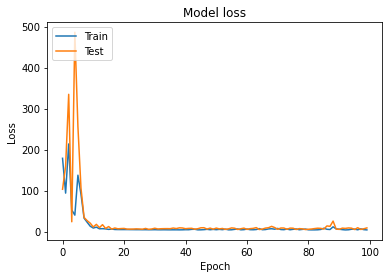

In [11]:
#Plotting the loss of our model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

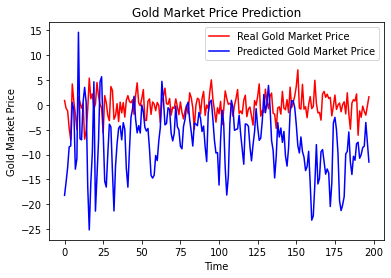

In [12]:
#Plotting predictions vs. Actual
plt.plot(arr_test_labels, color = 'red', label = 'Real Gold Market Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Gold Market Price')
plt.title('Gold Market Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Market Price')
plt.legend()
plt.show()